In [1]:
#pip install statsforecast

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_novo = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])

In [4]:
df_novo.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df_novo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 137.4+ MB


In [6]:
df_novo['store_nbr'].nunique()

54

In [7]:
df_1 = df_novo.loc[df_novo['store_nbr']==1, ['date','family','sales']]
df_1 = df_1.rename(columns={'date':'ds', 'sales':'y','family':'unique_id'})

In [8]:
df_1

,ds,unique_id,y
id,,,
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,0.000000
3,2013-01-01,BEVERAGES,0.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
2999134,2017-08-15,POULTRY,234.892000
2999135,2017-08-15,PREPARED FOODS,42.822998
2999136,2017-08-15,PRODUCE,2240.230000


## VIDEO 2

In [9]:
treino = df_1.loc[df_1['ds'] < '2014-01-01']
valid = df_1.loc[(df_1['ds'] >= '2014-01-01') & (df_1['ds'] < '2014-04-01')]
                                                
h = valid['ds'].nunique()                                                
                                                

In [10]:
h # 3 meses selecionados acima - 90 dias

90

MAPE -   
WMAPE -

In [11]:
def wmape(y_true, y_pred):
    return np.abs((y_true - y_pred).sum() / np.abs(y_true).sum())

RMSE - Erro quadrado medio

## VIDEO 3

In [18]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

C:\Users\papel\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:42.67%


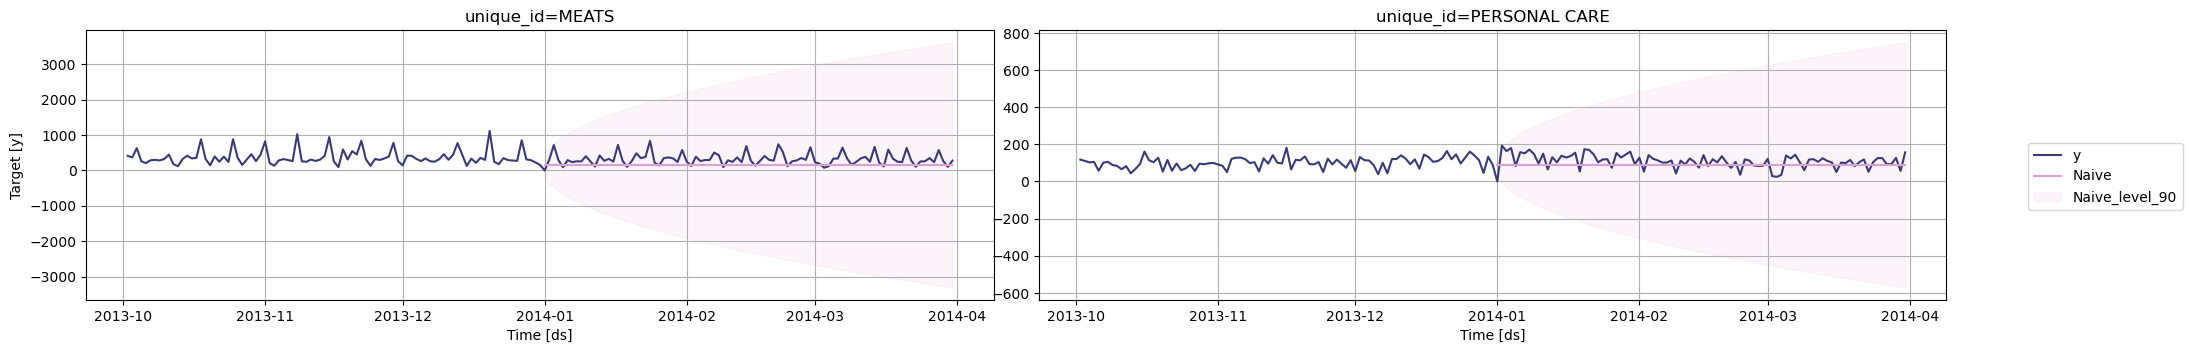

In [13]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.reset_index().merge(valid,on=['ds','unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f'WMAPE:{wmape1:.2%}')

model.plot(treino,forecast_df,level=[90], unique_ids=['MEATS','PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

In [14]:
forecast_df

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,AUTOMOTIVE,2014-01-01,2.000,-2.671534,6.671534,0.0000
1,AUTOMOTIVE,2014-01-02,2.000,-4.606546,8.606546,3.0000
2,AUTOMOTIVE,2014-01-03,2.000,-6.091333,10.091333,0.0000
3,AUTOMOTIVE,2014-01-04,2.000,-7.343067,11.343067,0.0000
4,AUTOMOTIVE,2014-01-05,2.000,-8.445867,12.445867,1.0000
...,...,...,...,...,...,...
2965,SEAFOOD,2014-03-27,13.933,-181.675537,209.541534,31.3880
2966,SEAFOOD,2014-03-28,13.933,-182.809509,210.675507,63.2869
2967,SEAFOOD,2014-03-29,13.933,-183.936981,211.802979,33.6150
2968,SEAFOOD,2014-03-30,13.933,-185.058060,212.924057,18.3520


C:\Users\papel\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:30.97%


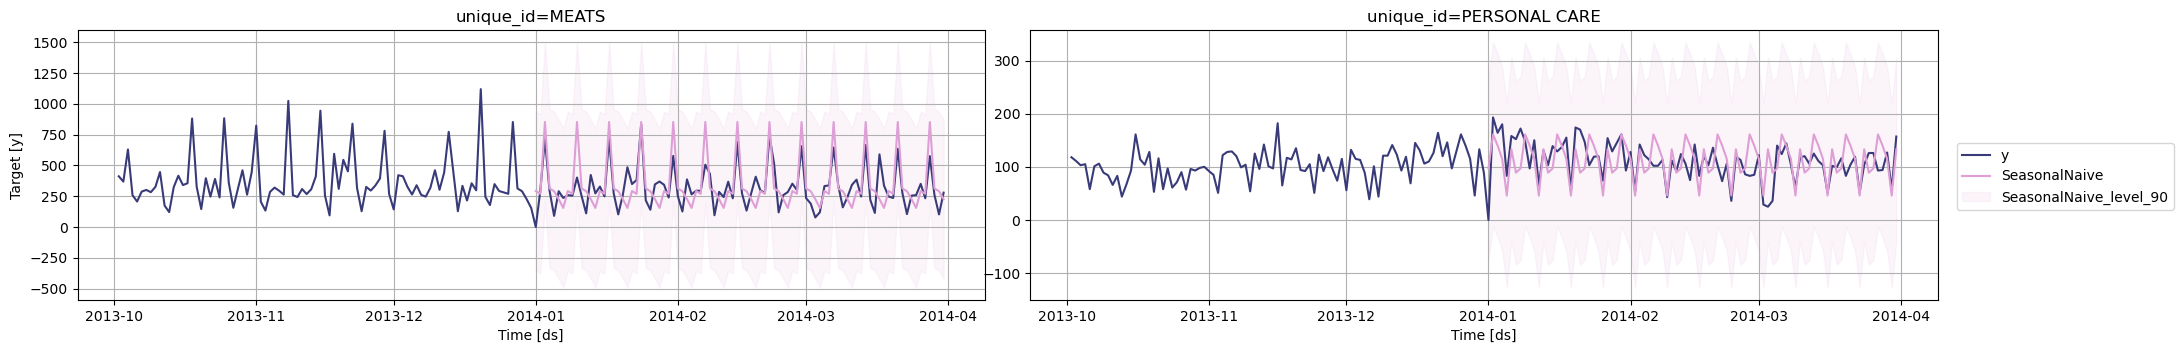

In [15]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid,on=['ds','unique_id'], how='left')

wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f'WMAPE:{wmape2:.2%}')

model_s.plot(treino,forecast_dfs,level=[90], unique_ids=['MEATS','PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

In [22]:
#media movel
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_sm = model_sm.predict(h=h, level=[90])
forecast_sm = forecast_sm.reset_index().merge(valid,on=['ds','unique_id'], how='left')

wmape3 = wmape(forecast_sm['y'].values, forecast_sm['SeasWA'].values)
print(f'WMAPE:{wmape3:.2%}')

model_sm.plot(treino,forecast_sm,level=[90], unique_ids=['MEATS','PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

Exception: You must pass `prediction_intervals` to compute them.

## VIDEO 5

C:\Users\papel\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE:25.68%


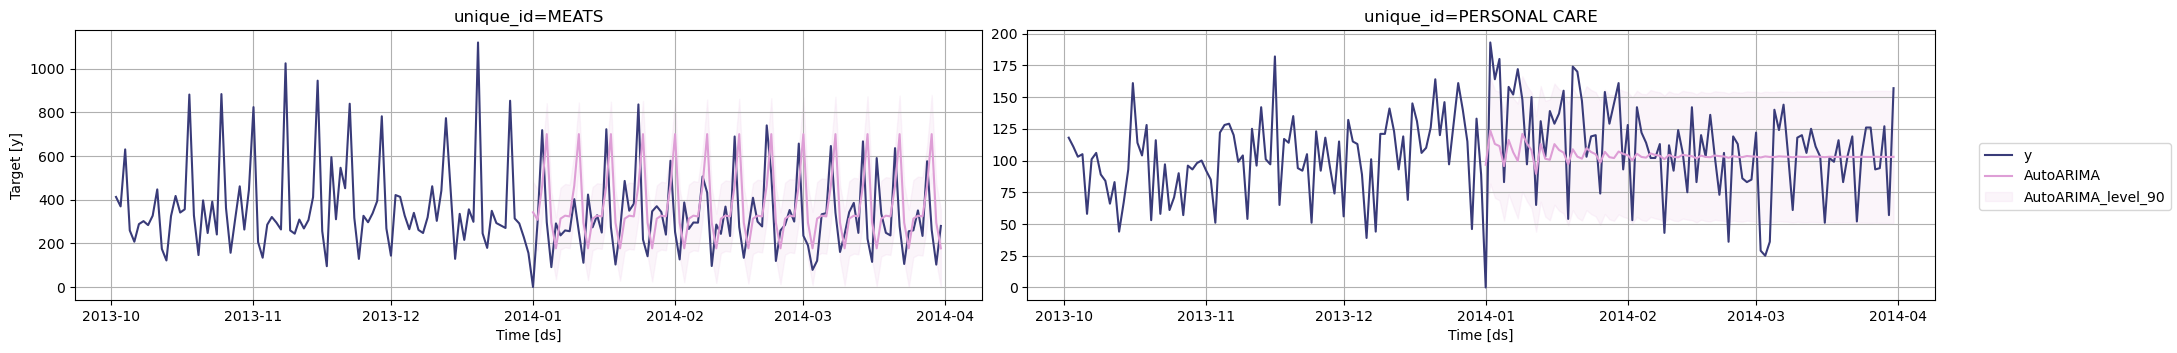

In [21]:
#ARIMA - 
# AR: olha para as vendas do passado e acha uma correlaçao futura
# I: quantidade que a série foi diferenciada
# MA: Média Móvel

model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_a = model_a.predict(h=h, level=[90])
forecast_a = forecast_a.reset_index().merge(valid,on=['ds','unique_id'], how='left')

wmape4 = wmape(forecast_a['y'].values, forecast_a['AutoARIMA'].values)
print(f'WMAPE:{wmape4:.2%}')

model_a.plot(treino,forecast_a,level=[90], unique_ids=['MEATS','PERSONAL CARE'], engine='matplotlib', max_insample_length=90)

